In [1]:
import glob
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from typing import Callable, Optional
from  torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py 
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/triplet_loss.py

--2021-05-17 15:13:52--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9794 (9.6K) [text/plain]
Saving to: ‘model.py.1’

model.py.1          100%[===================>]   9.56K  --.-KB/s    in 0s      

2021-05-17 15:13:52 (76.7 MB/s) - ‘model.py.1’ saved [9794/9794]

--2021-05-17 15:13:52--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1343 (1.3K) [text/plain]
Saving to: ‘datasets.py.1’


In [4]:
import triplet_loss
from model import ResNet
from datasets import AttDataset, YaleDataset

In [5]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19


In [6]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [7]:
process = transforms.Compose([
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

In [8]:
train_data = AttDataset(PATH, transform=process)
train_data

Dataset AttDataset
    Number of datapoints: 400
    Root location: /content/drive/MyDrive/Colab Notebooks/att_face_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

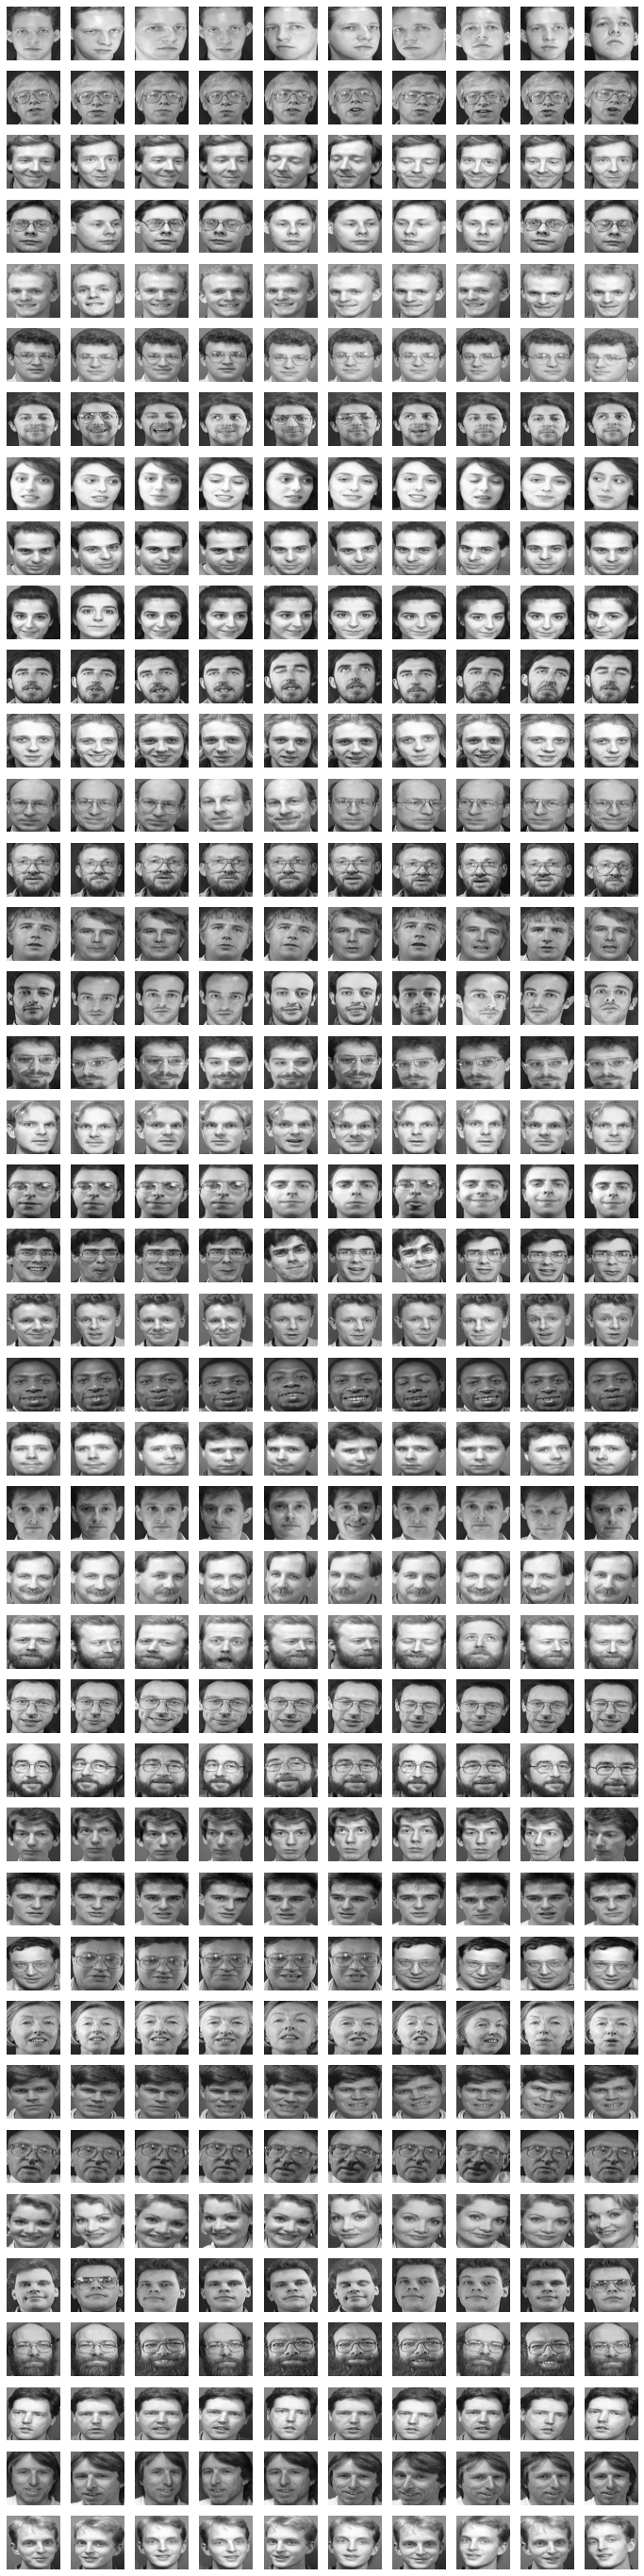

In [11]:
_,axxr = plt.subplots(40,10, figsize=(12,50))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(train[i][0].squeeze(), cmap="gray")
    ax.axis('off')
plt.axis('off')
plt.savefig("train_data.png", dpi=300)
plt.show()

In [ ]:
# Ref : http://vision.ucsd.edu/content/yale-face-database
'''
!wget http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
!unzip yalefaces.zip

import os, shutil, glob
for i in range(1,16):
    files = glob.glob(f'yalefaces/subject{i:02d}*')
    for f in files:
        des = f'yalefaces/subject{i:02d}'
        if not os.path.exists(des):
            os.makedirs(des)
        shutil.move(f, des)
'''

In [9]:
test = YaleDataset(
    path = "/content/drive/MyDrive/Colab Notebooks/yalefaces" ,
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
)
test

Dataset YaleDataset
    Number of datapoints: 165
    Root location: /content/drive/MyDrive/Colab Notebooks/yalefaces
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [28]:
ax.spines.values()

odict_values([<matplotlib.spines.Spine object at 0x7fca21605b50>, <matplotlib.spines.Spine object at 0x7fca21605d10>, <matplotlib.spines.Spine object at 0x7fca21605e90>, <matplotlib.spines.Spine object at 0x7fca21606050>])

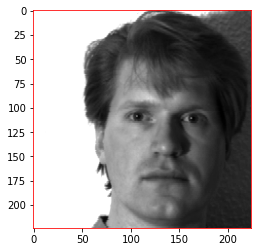

In [33]:
ax = plt.subplot()
ax.imshow(test[3][0].squeeze(), cmap='gray')
for spine in ax.spines.values():
    spine.set_color("red")
ax.set_xticks([])
ax.set_yticks([])



plt.show()

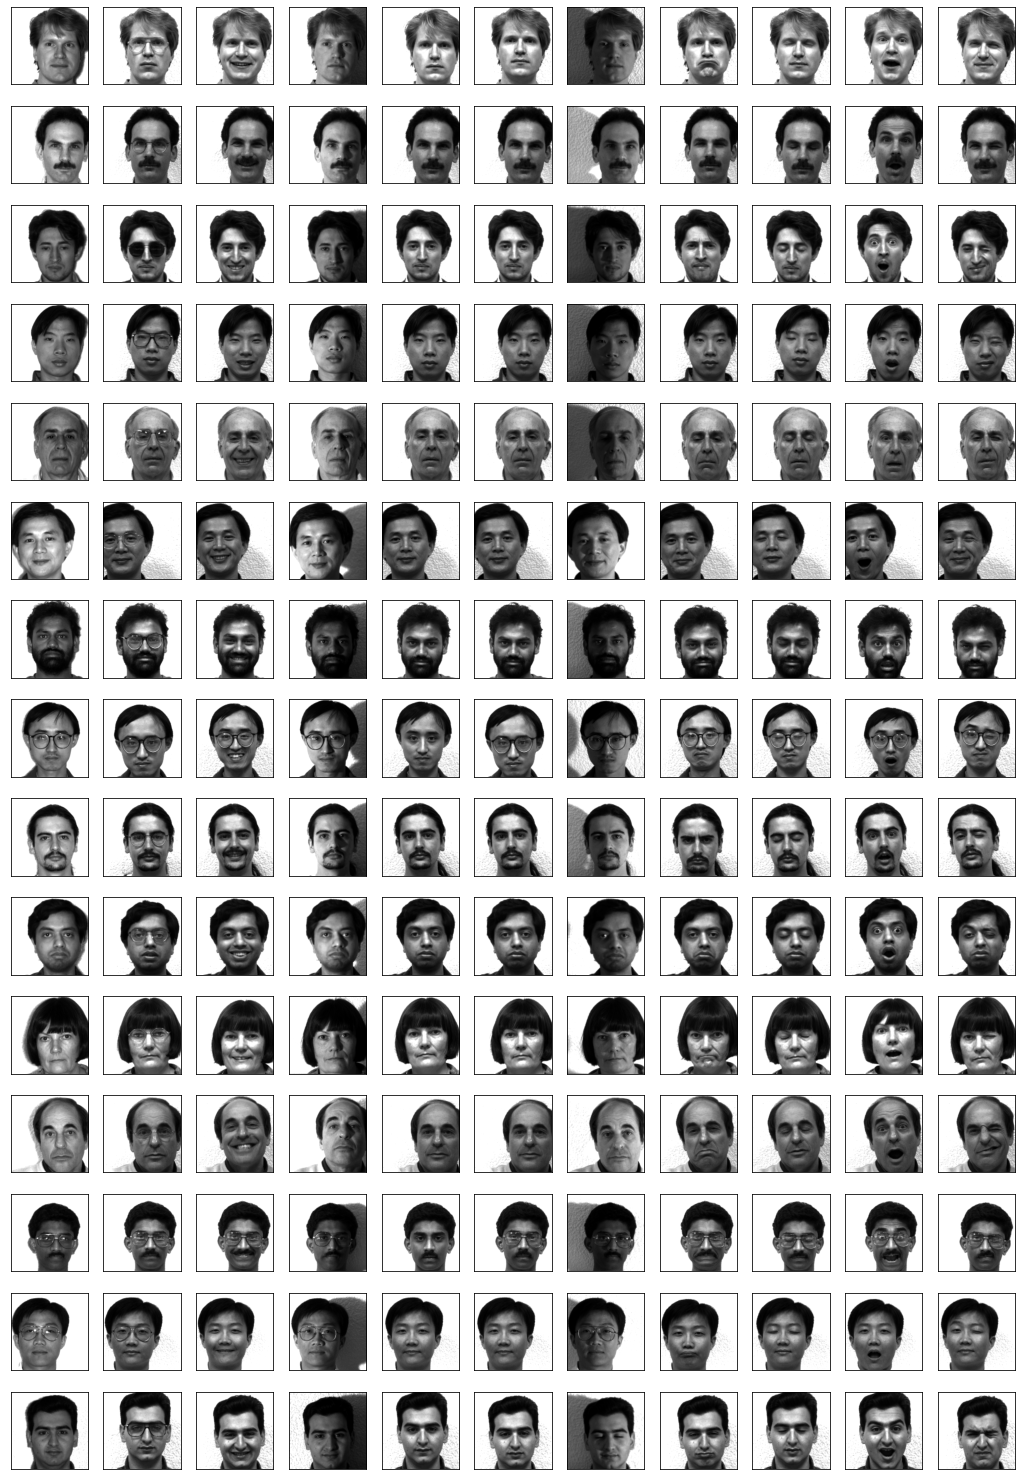

In [45]:
_,axxr = plt.subplots(15,11, figsize=(18,27))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(test[i][0].squeeze(), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('test_data.png', dpi=300)
plt.show()

In [9]:
!pip install wandb
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
import wandb
# 1. Start a new run
wandb.init(project="Face-Unlock")

wandb: WARNING Ignored wandb.init() arg project when running a sweep


In [22]:
resnet18 = ResNet()
resnet18.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
def Triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [23]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.epochs = 100
config.classes = 40
config.batch_size = 40
config.learning_rate = 0.05
config.train_dataset = "AttDataset"
config.test_dataset = "YaleDataset"
config.architechture = "ResNet18"

Error: ignored

In [51]:
loader = torch.utils.data.DataLoader(train, batch_size = config.batch_size, shuffle=True)
optimizer18 = optim.Adam(resnet18.parameters(), lr = config.learning_rate)
scheduler18 = optim.lr_scheduler.ReduceLROnPlateau(optimizer18, factor=0.5, patience=2, min_lr=0.00001, verbose=True)
torch_triplet_loss = nn.TripletMarginLoss()

In [52]:
image, label = next(iter(loader))
image.shape, label.shape

(torch.Size([40, 1, 224, 224]), torch.Size([40]))

In [53]:
wandb.watch(resnet18, criterion='all')

In [ ]:
total_loss = []
epochs_loss =[]
for epoch in range(config.epochs):
    epoch_loss = 0
    for step, (images, labels) in enumerate(loader):
        print(f"Epoch: {epoch:02d}, Step: {step:02d},", end=" ")
        start_time = time.time()

        embds = resnet18(images.to(device)).to('cpu')

        loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
        epoch_loss += loss.item()
        wandb.log({"loss": loss.item()})
        print(f"Loss: {loss.item():.3f}, +ve triplets: {fpt:.2f},", end=" ")

        optimizer18.zero_grad()
        loss.backward()
        optimizer18.step()

        current_time = time.time()
        print("Time: {:.4f}s".format(current_time-start_time))
    wandb.log({"epoch_loss": epoch_loss})
    epochs_loss.append(epoch_loss)

Epoch: 00, Step: 00, Loss: 0.688, +ve triplets: 0.73, Time: 0.4943s
Epoch: 00, Step: 01, Loss: 0.701, +ve triplets: 0.79, Time: 0.3418s
Epoch: 00, Step: 02, Loss: 0.800, +ve triplets: 0.52, Time: 0.3336s
Epoch: 00, Step: 03, Loss: 0.856, +ve triplets: 0.56, Time: 0.3545s
Epoch: 00, Step: 04, Loss: 0.808, +ve triplets: 0.45, Time: 0.3445s
Epoch: 00, Step: 05, Loss: 1.083, +ve triplets: 0.49, Time: 0.3428s
Epoch: 00, Step: 06, Loss: 1.048, +ve triplets: 0.38, Time: 0.3242s
Epoch: 00, Step: 07, Loss: 0.761, +ve triplets: 0.34, Time: 0.3590s
Epoch: 00, Step: 08, Loss: 0.542, +ve triplets: 0.36, Time: 0.3652s
Epoch: 00, Step: 09, Loss: 0.464, +ve triplets: 0.28, Time: 0.3273s
Epoch: 01, Step: 00, Loss: 0.389, +ve triplets: 0.24, Time: 0.2395s
Epoch: 01, Step: 01, Loss: 0.616, +ve triplets: 0.29, Time: 0.2385s
Epoch: 01, Step: 02, Loss: 0.449, +ve triplets: 0.17, Time: 0.2361s
Epoch: 01, Step: 03, Loss: 0.551, +ve triplets: 0.28, Time: 0.2355s
Epoch: 01, Step: 04, Loss: 0.455, +ve triplets: 

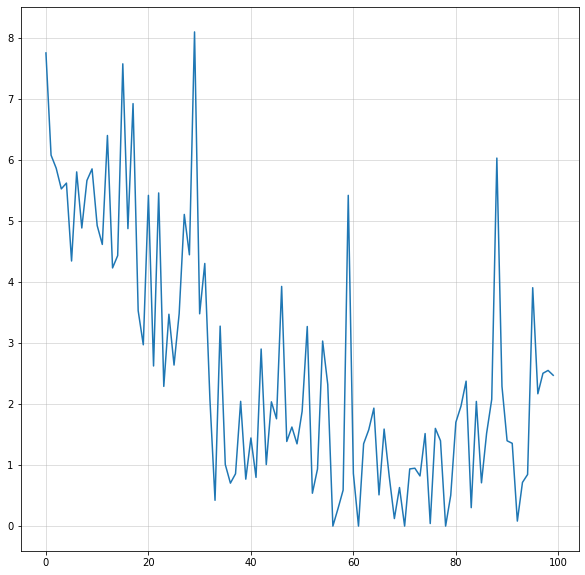

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epochs_loss, label="EpochLoss")
plt.grid(alpha=0.5)

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1).pow(.5)

In [ ]:
resnet18.eval()

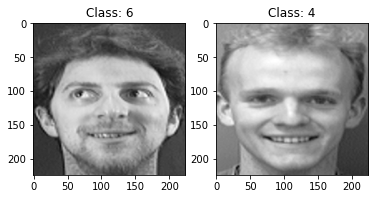

In [ ]:
_,(i1,i2) = plt.subplots(1,2)

img1 = train[63]#[0]
img2 = train[42]#[0]

i1.imshow(img1[0].squeeze(), cmap='gray')
i1.title.set_text(f'Class: {img1[1]}')
i2.imshow(img2[0].squeeze(), cmap='gray')
i2.title.set_text(f'Class: {img2[1]}')

embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')

In [ ]:
dist(embd[0], embd[1]).pow(.5)

tensor(4.2273, grad_fn=<PowBackward0>)

In [54]:
tl = torch.utils.data.DataLoader(train, batch_size = 400)

In [55]:
tl = next(iter(tl))

In [56]:
images, labels = tl
images.shape, labels.shape

(torch.Size([400, 1, 224, 224]), torch.Size([400]))

In [ ]:
# resnet18.cpu()
embeddings = resnet18(images.cuda()).cpu()
embeddings.shape

In [58]:
from sklearn.manifold import TSNE

In [59]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embeddings.detach().numpy())

In [66]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(60,60))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 40.),
                 fontdict={'weight': 'heavy', 'size': 30})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid()
    plt.title(title)
    return fig

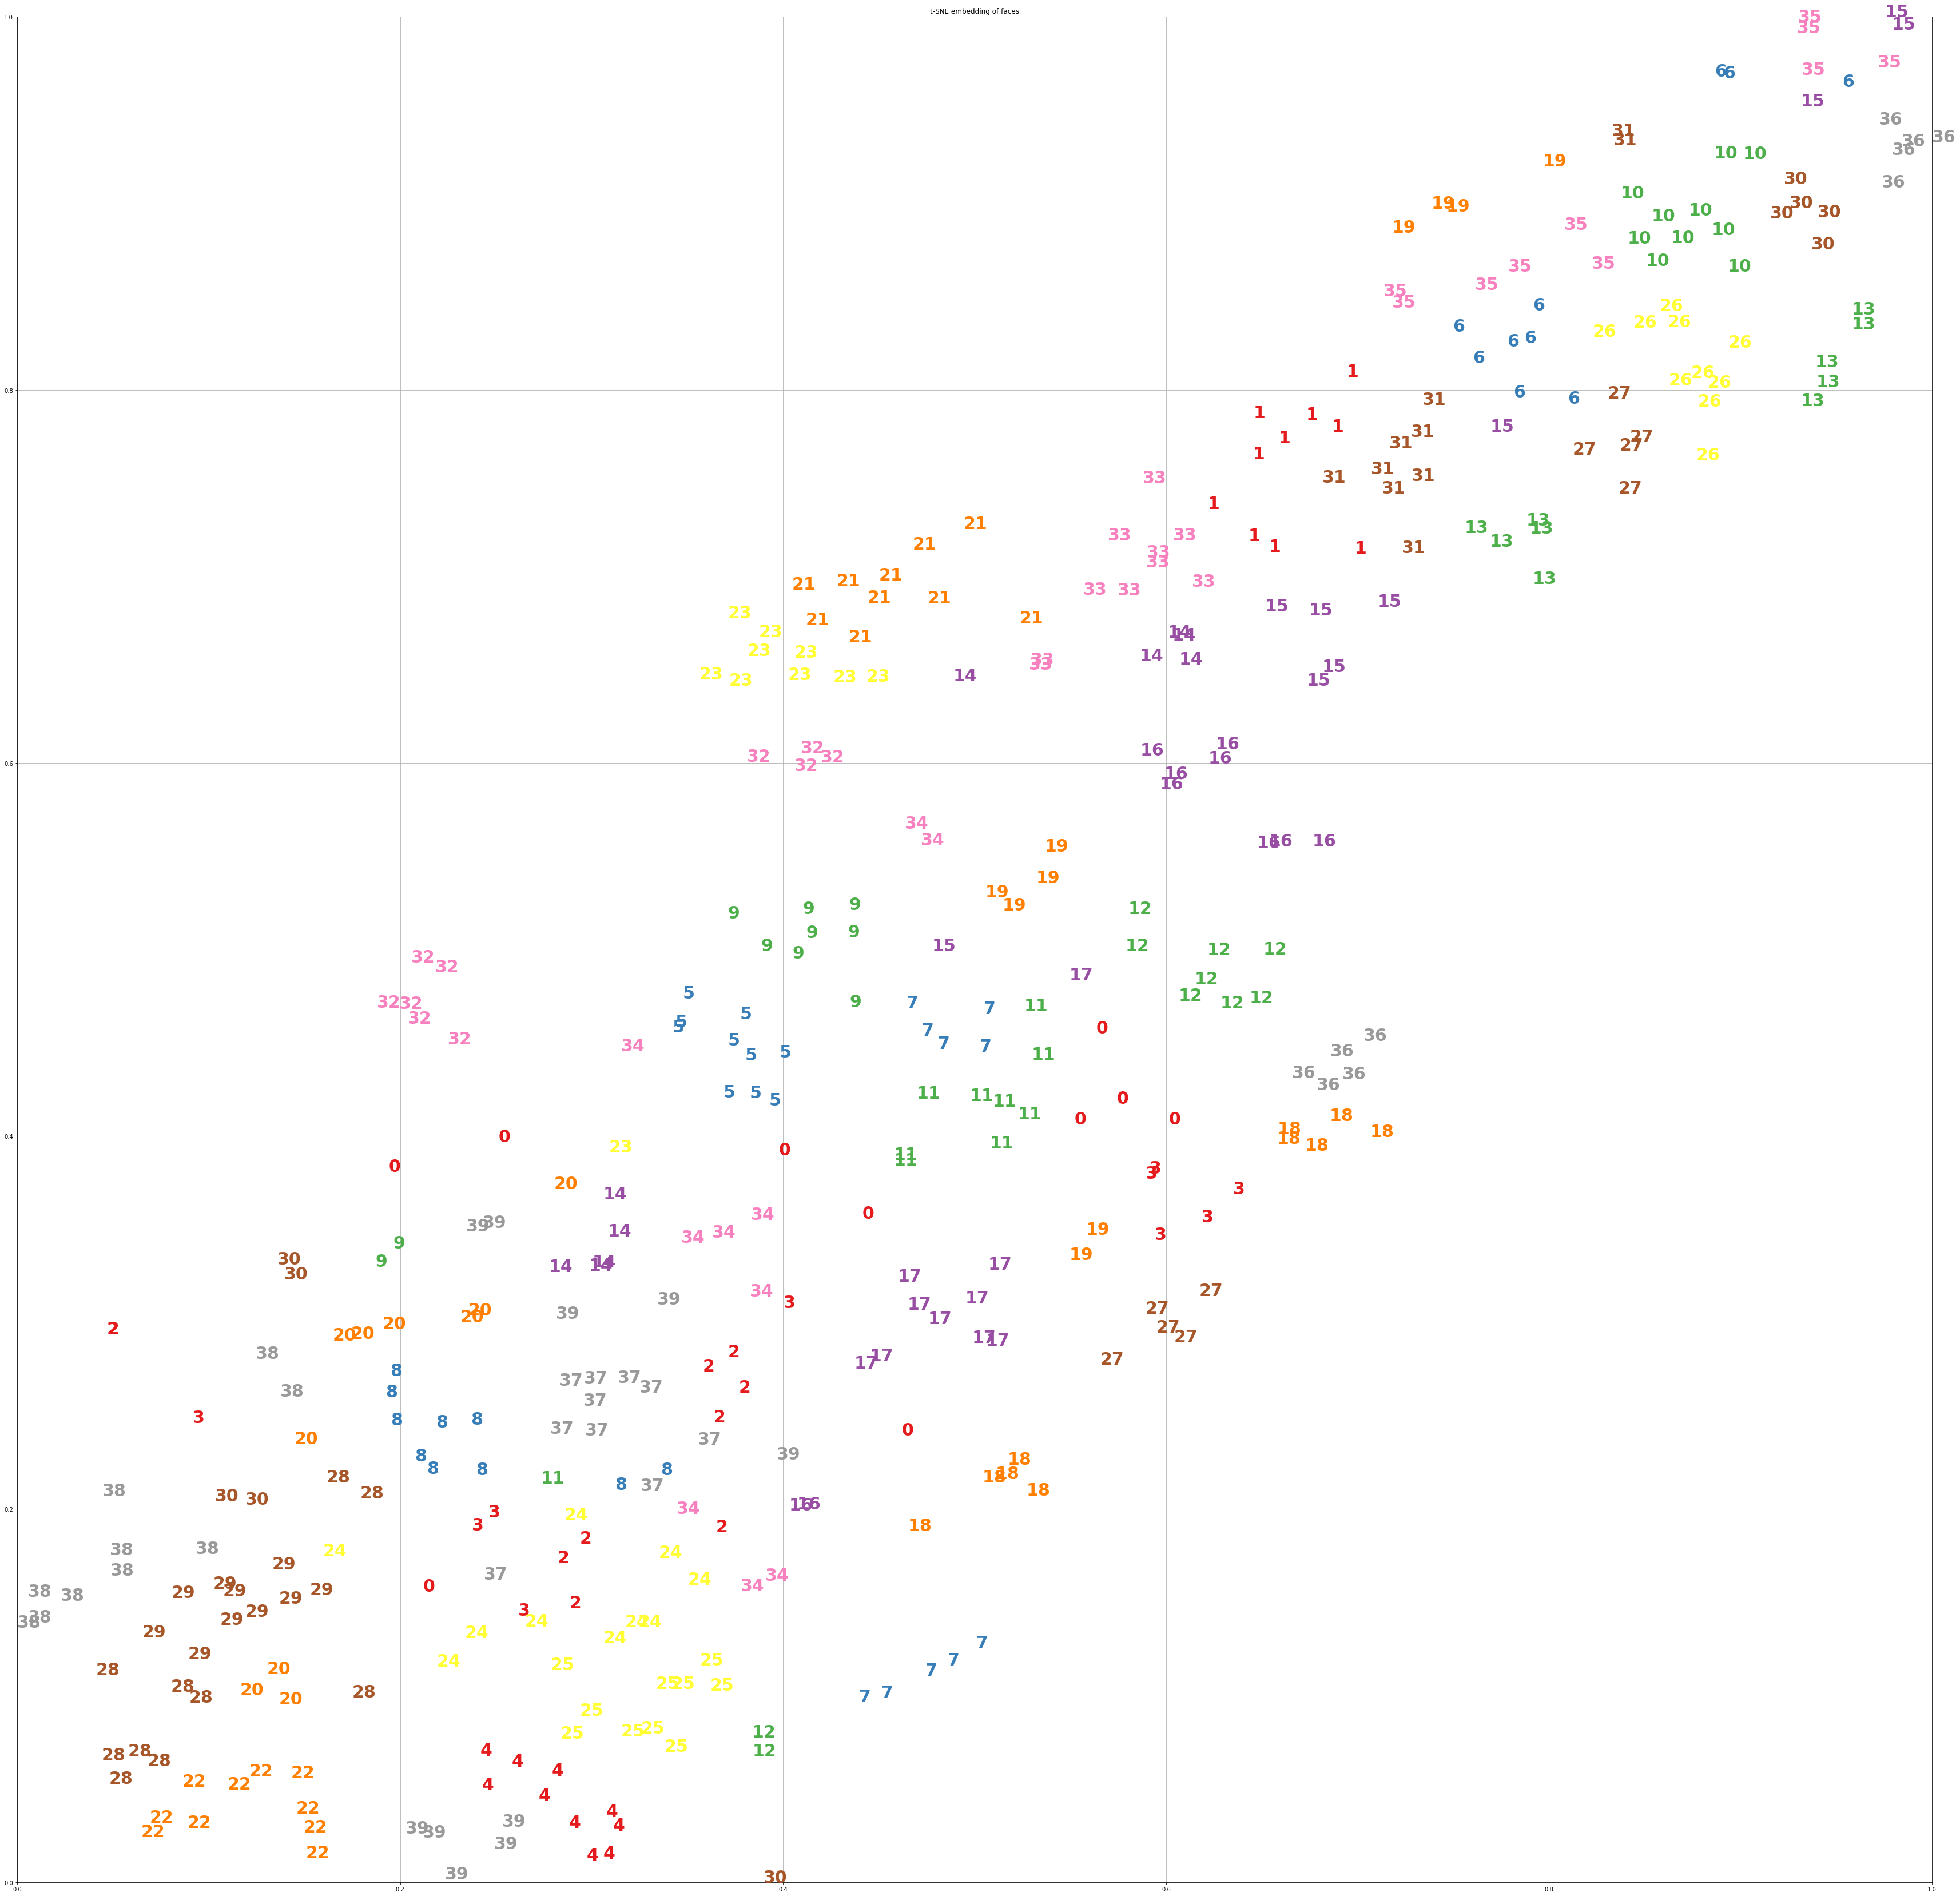

<Figure size 432x288 with 0 Axes>

In [67]:
fig = plot_embedding(reduced, labels.detach().numpy(),'t-SNE embedding of faces')
plt.show(fig)
plt.savefig("t-SNE_visualization_of_embeddings.png")

In [ ]:
torch.save(resnet18.state_dict(), "/content/drive/MyDrive/Colab Notebooks/facenet1.pth")

In [77]:
resnet18.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/facenet1.pth"))
# resnet18.eval()

<All keys matched successfully>

## Testing

In [69]:
distances = triplet_loss._pairwise_distances(embeddings)
distances.shape

torch.Size([400, 400])

In [70]:
ap_mask = triplet_loss._get_anchor_positive_triplet_mask(labels).detach().numpy()
ap_mask.shape

(400, 400)

In [78]:
preds = distances < 4.7

In [ ]:
preds.sum() , ap_mask.sum()

(tensor(3598), 3600)

In [72]:
preds.sum() , ap_mask.sum()

(tensor(159816), 3600)

In [ ]:
true_accepts = np.logical_and(preds, ap_mask)
true_accepts.sum()

tensor(3194)

In [73]:
true_accepts = np.logical_and(preds, ap_mask)
true_accepts.sum()

tensor(3600)

In [ ]:
VAL = true_accepts.sum() / ap_mask.sum()
VAL

tensor(0.8872)

In [74]:
VAL = true_accepts.sum() / ap_mask.sum()
VAL

tensor(1.)

In [75]:
false_accepts = np.logical_and(preds, np.logical_not(ap_mask))
false_accepts.sum()

tensor(156216)

In [76]:
FAR = false_accepts.sum() / np.logical_not(ap_mask).sum()
FAR

tensor(0.9988)

In [ ]:
np.sum(np.logical_and(np.logical_not(preds.detach().numpy()), ap_mask))

406

In [ ]:
def far_frr_curve(threshold, dist, ap_mask):
    preds = dist < threshold

    false_accept = np.sum(np.logical_and(preds, np.logical_not(ap_mask)))
    false_reject = np.sum(np.logical_and(np.logical_not(preds), ap_mask))

    return false_accept, false_reject

In [ ]:
far = []
frr = []
x = np.arange(10, step =0.1)
for threshold in x:
    a, b = far_frr_curve(threshold, distances.detach().numpy(), ap_mask)
    far.append(a)
    frr.append(b)

In [ ]:
eer = 160000
optimal_thrshold = 25
for i in range(len(x)):
    a,b = far[i], frr[i]
    if abs(a-b) < eer:
        eer = abs(a-b)
        optimal_thrshold = x[i]
        y = b

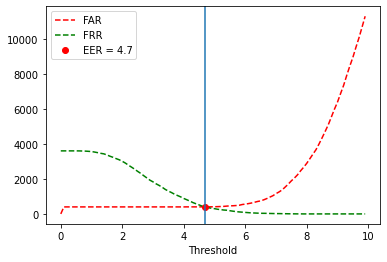

optimal_thrshold: 4.7


<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

ax.plot(x, far, 'r--', label='FAR')
ax.plot(x, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(optimal_thrshold, y,'ro', label=f'EER = {optimal_thrshold}') 
plt.axvline(optimal_thrshold)

ax.legend()
plt.show()
plt.savefig("far_frr_curve.png")

print("optimal_thrshold:", optimal_thrshold)

In [ ]:
# ref : https://github.com/tamerthamoqa/facenet-pytorch-glint360k/blob/c932b45b5784b70a841398a366cd85d65918519c/validate_on_LFW.py#L109
def calculate_metrics(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else \
        float(true_positives) / float(true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else \
        float(false_positives) / float(false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else\
        float(true_positives) / float(true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else \
        float(true_positives) / float(true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    return true_positive_rate, false_positive_rate, precision, recall, accuracy

In [ ]:
print("True Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nAccuracy: {:.3f}".format(*calculate_metrics(4.7, distances.detach().numpy(), ap_mask)))

True Acceptance: 0.887
False Acceptance: 0.003
Precision: 0.888
Recall: 0.887
Accuracy: 0.995


# Test on test dataset

In [ ]:
test_loader = DataLoader(test, batch_size=165)
len(test_loader)

1

In [ ]:
test = next(iter(test_loader))
images, labels = test
images.shape, labels.shape

(torch.Size([165, 1, 224, 224]), torch.Size([165]))

In [ ]:
embeddings = resnet18(images.cuda()).cpu()
embeddings.shape

torch.Size([165, 128])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embeddings.detach().numpy())

In [ ]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(30,30))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 15.),
                 fontdict={'weight': 'bold', 'size': 27})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(alpha=0.5)
    plt.title(title)
    return fig

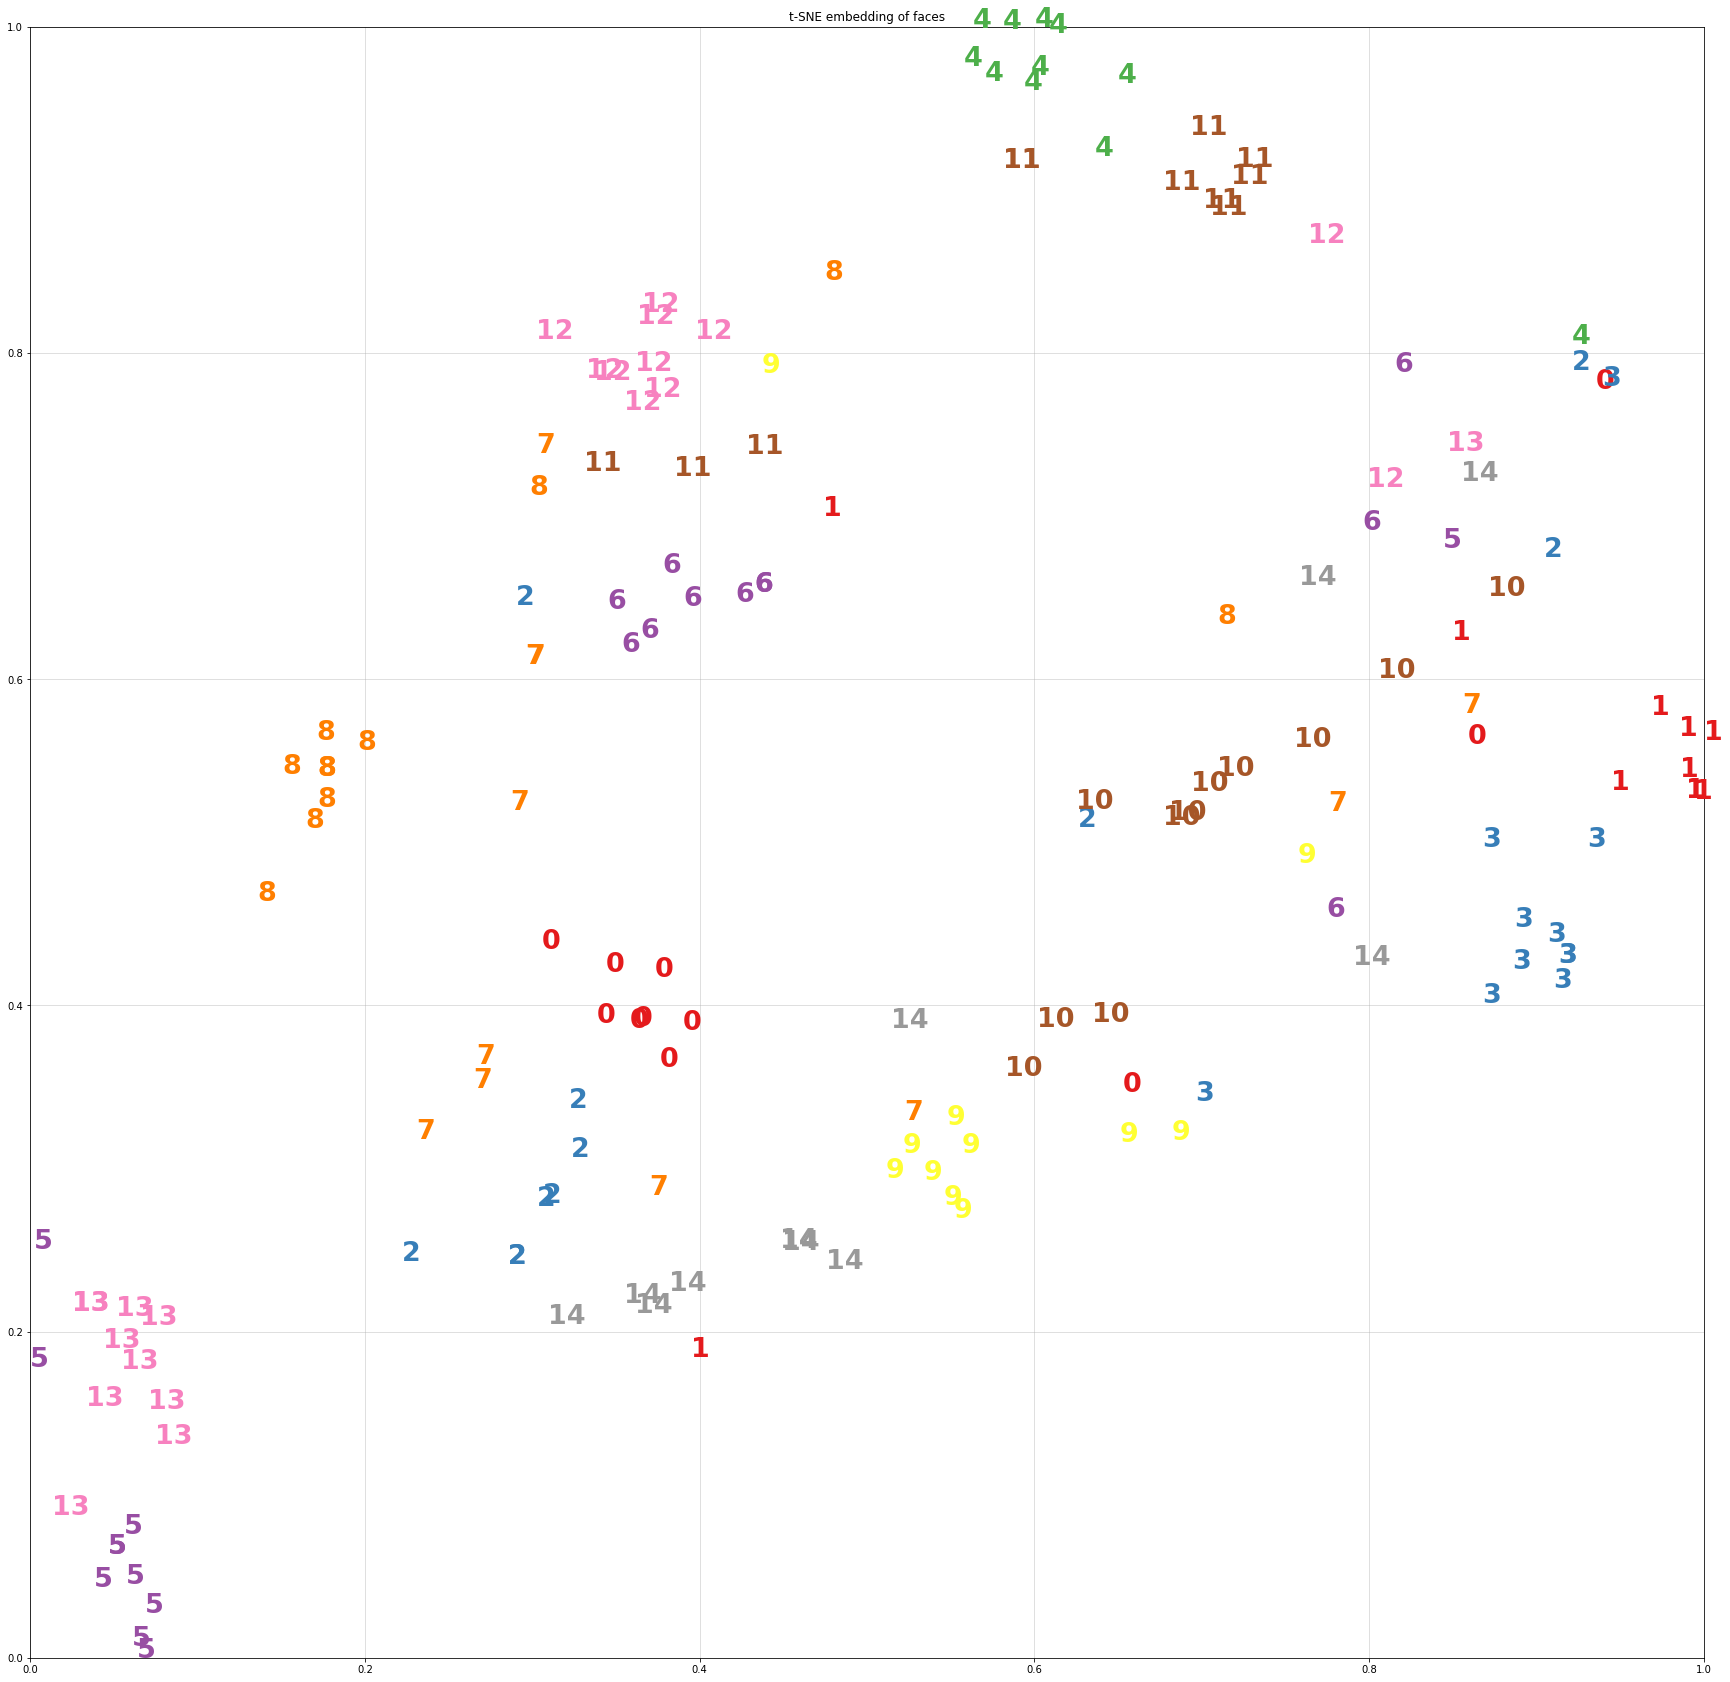

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plot_embedding(reduced, labels.detach().numpy(),'t-SNE embedding of faces')
plt.show(fig)
plt.savefig("t-SNE_visualization_of_test_embeddings.png")

In [ ]:
distances = triplet_loss._pairwise_distances(embeddings)
distances.shape

torch.Size([165, 165])

In [ ]:
ap_mask = triplet_loss._get_anchor_positive_triplet_mask(labels).detach().numpy()
ap_mask.shape

(165, 165)

In [ ]:
preds = distances < 1.8

In [ ]:
preds.sum() , ap_mask.sum()

(tensor(8465), 1650)

In [ ]:
true_accepts = np.logical_and(preds, ap_mask)
true_accepts.sum()

tensor(1198)

In [ ]:
VAL = true_accepts.sum() / ap_mask.sum()
VAL

tensor(0.7261)

In [ ]:
false_accepts = np.logical_and(preds, np.logical_not(ap_mask))
false_accepts.sum()

tensor(7267)

In [ ]:
FAR = false_accepts.sum() / np.logical_not(ap_mask).sum()
FAR

tensor(4.4042)

In [ ]:
np.sum(np.logical_and(np.logical_not(preds.detach().numpy()), ap_mask))

452

In [ ]:
def far_frr_curve(threshold, dist, ap_mask):
    preds = dist < threshold

    false_accept = np.sum(np.logical_and(preds, np.logical_not(ap_mask))) / np.sum(np.logical_not(ap_mask))
    false_reject = np.sum(np.logical_and(np.logical_not(preds), ap_mask)) / np.sum(ap_mask)

    return false_accept, false_reject

In [ ]:
far = []
frr = []
x = np.arange(-1, 5, step =0.1)
for threshold in x:
    a, b = far_frr_curve(threshold, distances.detach().numpy(), ap_mask)
    far.append(a)
    frr.append(b)

In [ ]:
eer = 160000
optimal_thrshold = 25
for i in range(len(x)):
    a,b = far[i], frr[i]
    if abs(a-b) < eer:
        eer = abs(a-b)
        optimal_thrshold = x[i]
        y = b

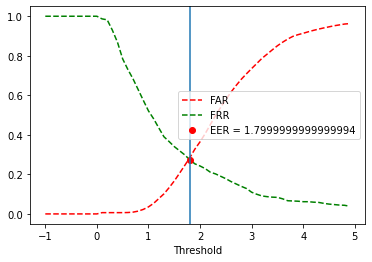

optimal_thrshold: 1.7999999999999994


<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

ax.plot(x, far, 'r--', label='FAR')
ax.plot(x, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(optimal_thrshold, y,'ro', label=f'EER = {optimal_thrshold}') 
plt.axvline(optimal_thrshold)

ax.legend()
plt.show()
plt.savefig("far_frr_curve.png")

print("optimal_thrshold:", optimal_thrshold)

In [ ]:
# ref : https://github.com/tamerthamoqa/facenet-pytorch-glint360k/blob/c932b45b5784b70a841398a366cd85d65918519c/validate_on_LFW.py#L109
def calculate_metrics(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else \
        float(true_positives) / float(true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else \
        float(false_positives) / float(false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else\
        float(true_positives) / float(true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else \
        float(true_positives) / float(true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    return true_positive_rate, false_positive_rate, precision, recall, accuracy

In [ ]:
print("True Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nAccuracy: {:.3f}".format(*calculate_metrics(1.8, distances.detach().numpy(), ap_mask)))

True Acceptance: 0.726
False Acceptance: 0.284
Precision: 0.142
Recall: 0.726
Accuracy: 0.716


In [ ]:
false_accept_idxs =  (false_accepts == 1).nonzero()
false_accept_idxs.shape

torch.Size([7267, 2])

In [ ]:
np.random.randint(0,7267, size=30)

array([2897, 1701,  537, 2893, 6216, 6921, 6036, 2163, 5072, 4851, 2046,
       1871, 2496, 6994,   99, 2008,  755,  797,  659, 3219, 7054,  423,
       3337, 2745, 4735,  544, 6687,  714, 2292,  151])

In [ ]:
false_accept_idxs[6687][0].item()

154

distance tensor(1.4846, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

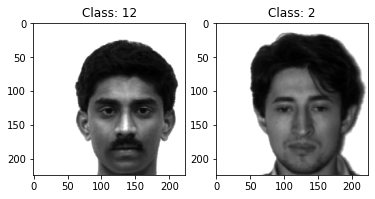

distance tensor(1.2999, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

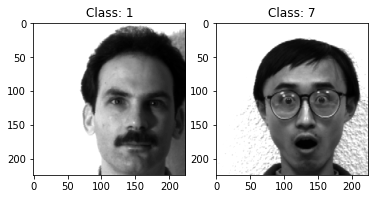

distance tensor(1.0217, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

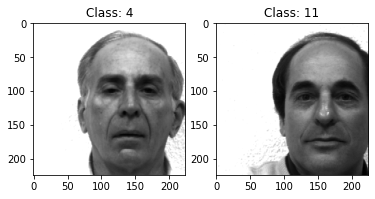

distance tensor(1.0217, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

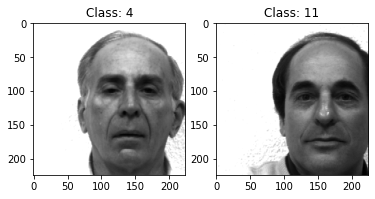

distance tensor(1.7954, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

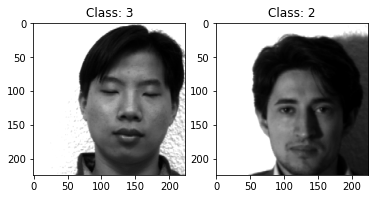

distance tensor(0.8636, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

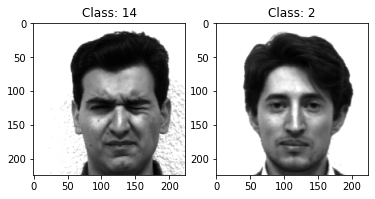

distance tensor(1.4574, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

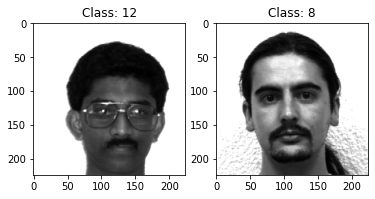

distance tensor(1.0928, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

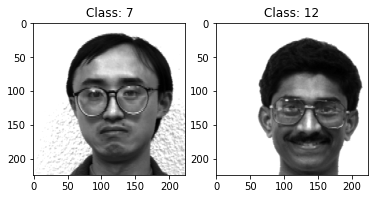

distance tensor(1.4004, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

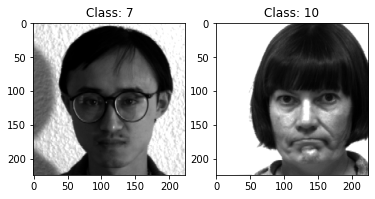

distance tensor(1.3135, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

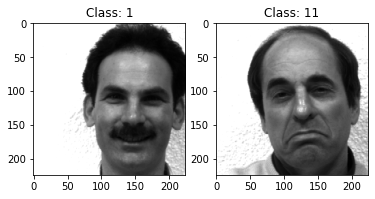

distance tensor(1.3605, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

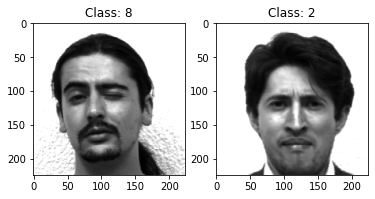

distance tensor(1.3530, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

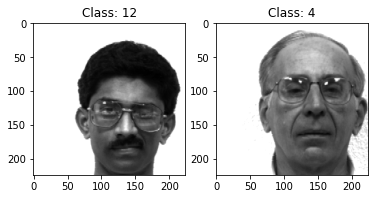

distance tensor(0.8715, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

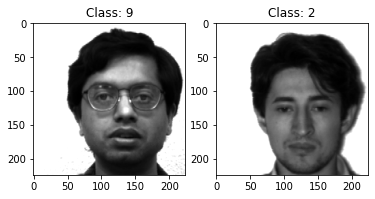

distance tensor(1.3586, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

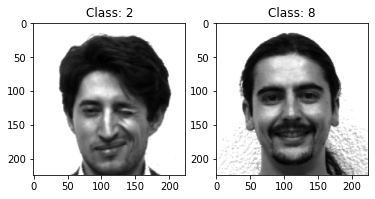

distance tensor(1.0815, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

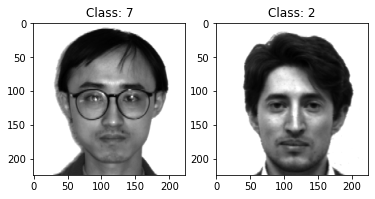

distance tensor(0.9348, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

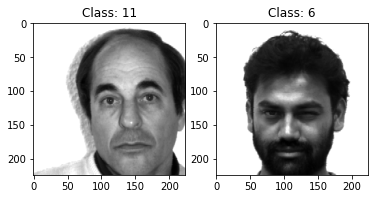

distance tensor(1.3683, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

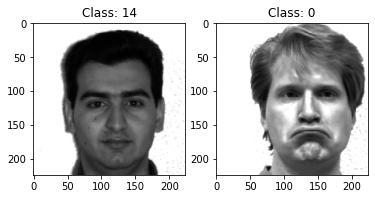

distance tensor(1.1895, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

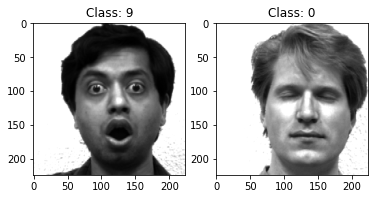

distance tensor(1.4886, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

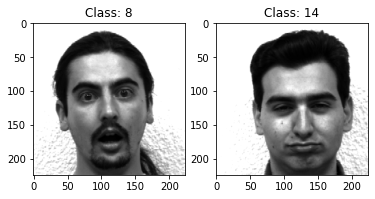

distance tensor(1.5852, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

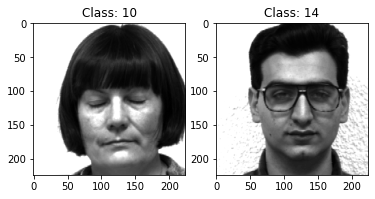

distance tensor(1.7691, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

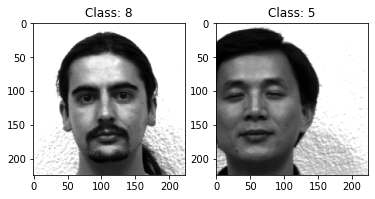

distance tensor(1.2074, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

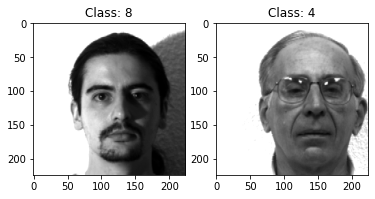

distance tensor(1.6135, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

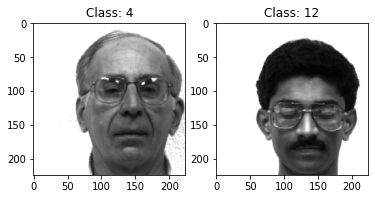

distance tensor(1.7800, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

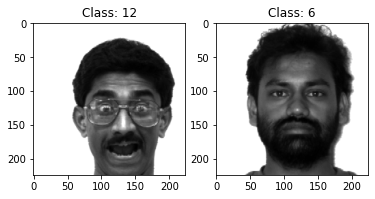

distance tensor(1.3428, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

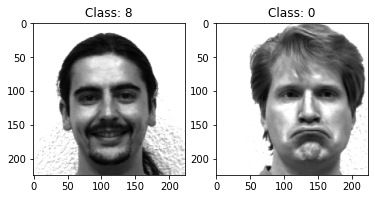

distance tensor(1.2143, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

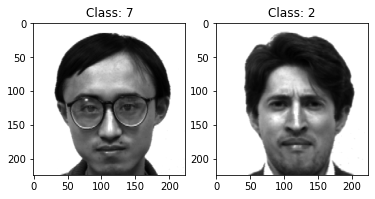

distance tensor(1.6087, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

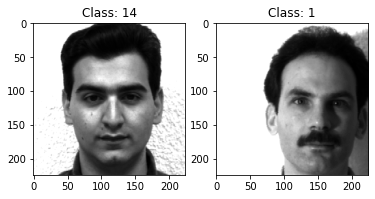

distance tensor(1.5030, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

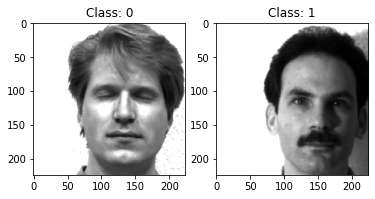

distance tensor(1.4915, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

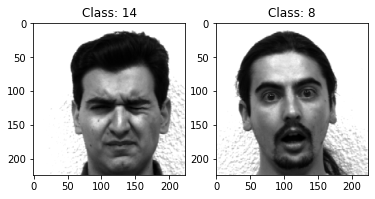

distance tensor(1.2256, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

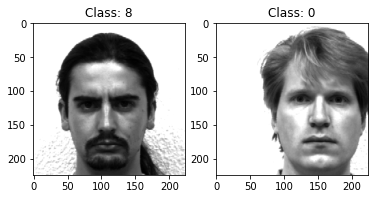

In [ ]:
for idx in np.random.randint(0,7267, size=30):
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)
    img1 = test[ false_accept_idxs[idx][0].item() ]
    img2 = test[ false_accept_idxs[idx][1].item() ]

    i1.imshow(img1[0].squeeze(), cmap='gray')
    i1.title.set_text(f'Class: {img1[1]}')
    i2.imshow(img2[0].squeeze(), cmap='gray')
    i2.title.set_text(f'Class: {img2[1]}')

    embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
    print('distance', dist(embd[0], embd[1]))
    plt.show()

Text(0.5, 1.0, '1.41117262840271')

<Figure size 432x288 with 0 Axes>

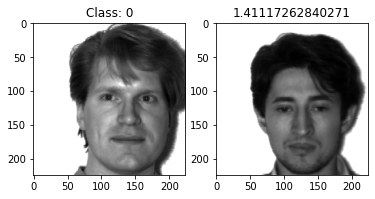

In [ ]:
plt.figure()
_,(i1,i2) = plt.subplots(1,2)

img1 = test[0]#[0]
img2 = test[22]#[0]

i1.imshow(img1[0].squeeze(), cmap='gray')
i1.title.set_text(f'Class: {img1[1]}')
i2.imshow(img2[0].squeeze(), cmap='gray')
i2.title.set_text(f'Class: {img2[1]}')

embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
dist(embd[0], embd[1])
plt.title(str(dist(embd[0], embd[1]).item()))

tensor(0., grad_fn=<PowBackward0>)

# Sweeps

In [10]:
import wandb

### Define Sweep

In [11]:
sweep_config = {
    'method': 'random' # grid, random, bayes
    }

In [12]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [13]:
parameter_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
    'fc_layer_size': {
        'values': [64, 128, 256]
    },
    'learning_rate': {
        'values': [0.01, 0.001, 0.0002, 0.0001]
    },
    'batch_size': {
        'values': [10,40,100,200]
    },
    'epochs': {
        'values': [1,10,50,100,200]
    }
}
sweep_config['parameters'] = parameter_dict

In [14]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [10, 40, 100, 200]},
                'epochs': {'values': [1, 10, 50, 100, 200]},
                'fc_layer_size': {'values': [64, 128, 256]},
                'learning_rate': {'values': [0.01, 0.001, 0.0002, 0.0001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


### Initialize Sweep

In [15]:
sweep_id = wandb.sweep(sweep_config, project='Face-Unlock')

Create sweep with ID: zrad7t99
Sweep URL: https://wandb.ai/abd1/Face-Unlock/sweeps/zrad7t99


In [ ]:
def evaluate(model, dataset, )

In [19]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'batch_size': 40,
        'epochs': 10,
        'fc_layer_size': 128,
        'learning_rate': 0.0001,
        'optimizer': 'adam',
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # define model
    network = ResNet()
    network.fc = nn.Sequential(
        nn.Linear(in_features=512*1, out_features = config.fc_layer_size),
        nn.ReLU(inplace=True)
    )
    network.to(device)
    # train loader 
    loader = DataLoader(train_data, batch_size = config.batch_size, shuffle=True)
    # optimizer
    if config.optimizer=='sgd':
        optimizer = optim.SGD(network.parameters(), lr=config.learning_rate, momentum=0.9)
    elif config.optimizer=='adam':
        optimizer = optim.Adam(network.parameters(), lr=config.learning_rate)

    network.train()
    network = network.to(device)
    for epoch in range(config.epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            embds = network(images.to(device)).to('cpu')
            loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt})
            loss.backward()
            optimizer.step()
        wandb.log({"epoch_loss": epoch_loss / config.batch_size})


### Run sweep Agent

In [21]:
wandb.agent(sweep_id, train, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: cwup6cn1 with config:
wandb: 	batch_size: 100
wandb: 	epochs: 100
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: adam


wandb: Agent Starting Run: 6d6swryk with config:
wandb: 	batch_size: 40
wandb: 	epochs: 100
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: adam


wandb: Agent Starting Run: u0ee0tcn with config:
wandb: 	batch_size: 100
wandb: 	epochs: 200
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


wandb: Agent Starting Run: 5qsdts7c with config:
wandb: 	batch_size: 200
wandb: 	epochs: 100
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


wandb: Agent Starting Run: 4iyyglft with config:
wandb: 	batch_size: 100
wandb: 	epochs: 100
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: adam
